### Imports

In [85]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.api import Holt

#personal imports
from acquire import opene2e
from prepare import prepare, summarize

import warnings
warnings.filterwarnings("ignore")

#Visual format
pd.options.display.float_format = '{:20,.2f}'.format

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

****Acquire
- acquired data from "add Link here"
- Initial shape 8.6M rows and 7 columns
- Choose Springfield, US
- Cached springfield.csv 

In [3]:
df = opene2e()
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.07,1.74,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


****Prepare
- temperature is in celcius/converted to F
- Rename all columns
- Keeping all columns for use later
- df shape reduced to (9545, 7)
- fill nulls with average temp and uncertainty respectively
- remove alpha characters from lat/long number
- change dtypes as necessary
    - lat/long to float
- change date to datetime and set index

In [4]:
df = prepare(df)
df.head()

,avg_temp,avgtemp_uncertainty,city,country,latitude,longitude
date,,,,,,
1963-09-01,56.28,32.31,Springfield,United States,42.59,72.00
1963-09-01,71.52,32.72,Springfield,United States,37.78,93.56
1963-09-01,67.94,32.57,Springfield,United States,39.38,89.48
1963-10-01,68.31,32.73,Springfield,United States,37.78,93.56
1963-10-01,65.50,32.30,Springfield,United States,39.38,89.48


In [5]:
summarize(df)

(1803, 6)
___________________________
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1803 entries, 1963-09-01 to 2013-09-01
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   avg_temp             1803 non-null   float64
 1   avgtemp_uncertainty  1803 non-null   float64
 2   city                 1803 non-null   object 
 3   country              1803 non-null   object 
 4   latitude             1803 non-null   float64
 5   longitude            1803 non-null   float64
dtypes: float64(4), object(2)
memory usage: 98.6+ KB
None
___________________________
avg_temp               0
avgtemp_uncertainty    0
city                   0
country                0
latitude               0
longitude              0
dtype: int64


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_temp,"1,803.00",52.48,17.64,12.60,37.06,54.24,68.23,86.44
avgtemp_uncertainty,"1,803.00",32.50,0.17,32.11,32.38,32.48,32.60,34.46
latitude,"1,803.00",39.92,2.00,37.78,37.78,39.38,42.59,42.59
longitude,"1,803.00",85.01,9.35,72.00,72.00,89.48,93.56,93.56


In [7]:
print('Date Range:', df.index.min(), 'to', df.index.max())

Date Range: 1963-09-01 00:00:00 to 2013-09-01 00:00:00


- seasonality: a repeated cycle in the data. Occurs at a fixed frequency. In our weather data there is yearly and daily seasonality
- trend: long term upwards or downwards movement
- cycle: Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

####Split

In [8]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

####Explore

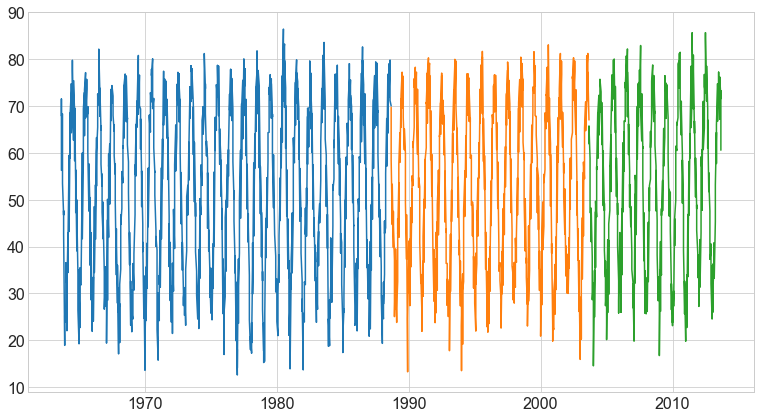

In [9]:
plt.plot(train.index, train.avg_temp)
plt.plot(validate.index, validate.avg_temp)
plt.plot(test.index, test.avg_temp)

In [10]:
y = train.avg_temp
y.head()

date
1963-09-01                  56.28
1963-09-01                  71.52
1963-09-01                  67.94
1963-10-01                  68.31
1963-10-01                  65.50
Name: avg_temp, dtype: float64

<AxesSubplot:ylabel='Frequency'>

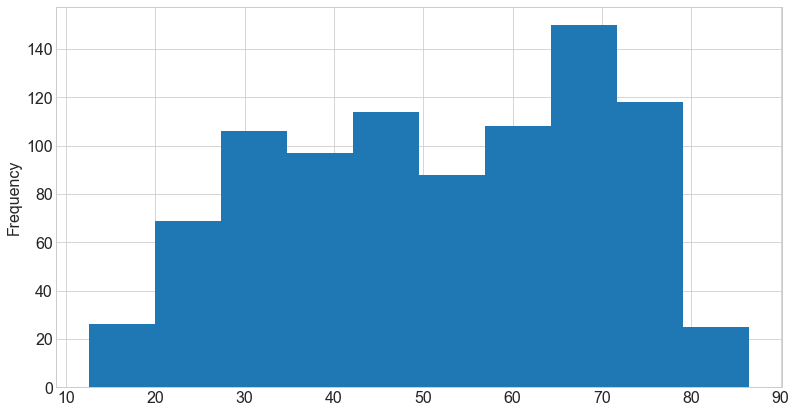

In [11]:
y.plot.hist()

[Text(0.5, 1.0, 'Average Temperature by Year'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Temp (F)')]

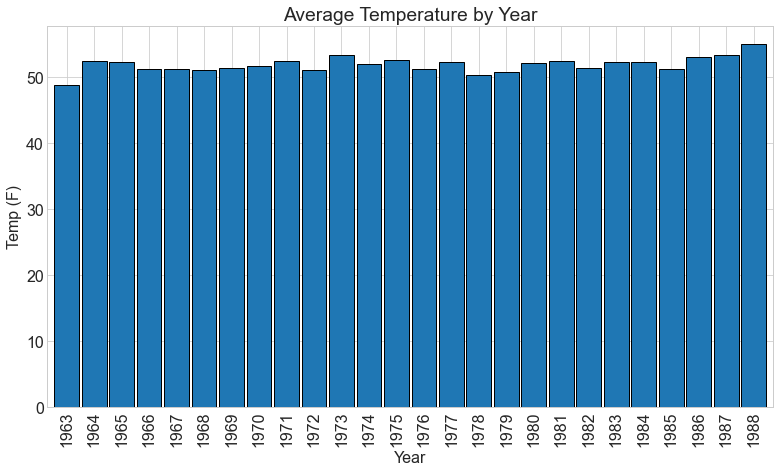

In [12]:
#Average temperature by year
ax = y.groupby(y.index.year).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=90)
ax.set(title='Average Temperature by Year', xlabel='Year', ylabel='Temp (F)')

[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temp (F)')]

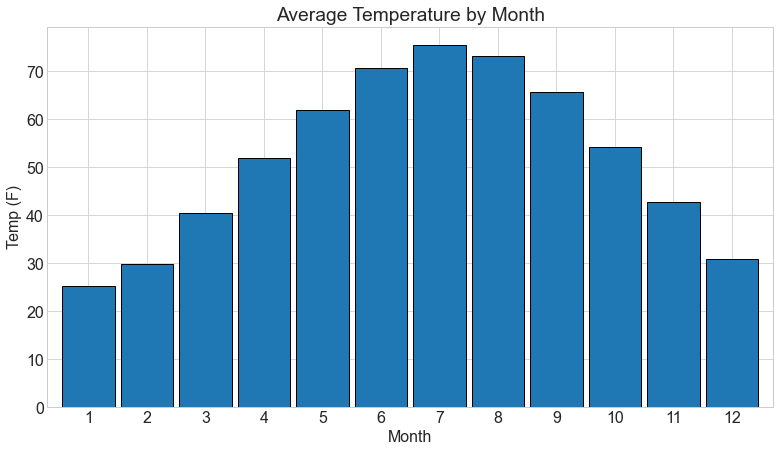

In [20]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (F)')

<AxesSubplot:xlabel='date'>

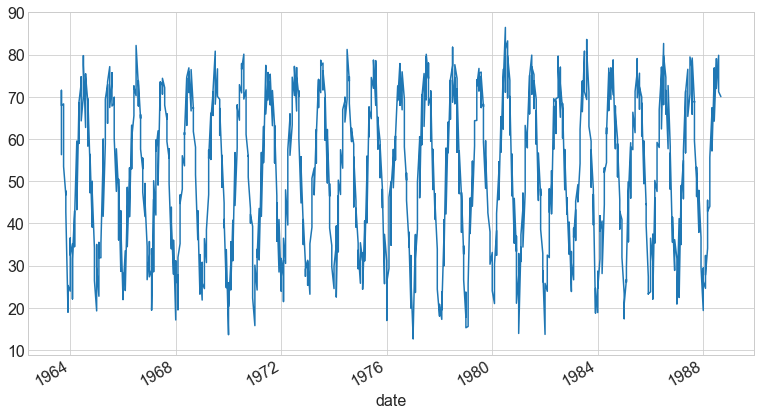

In [21]:
y.plot()

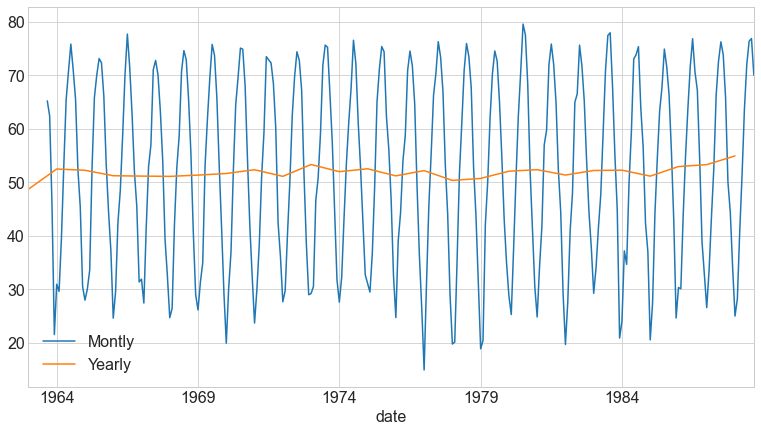

In [28]:
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

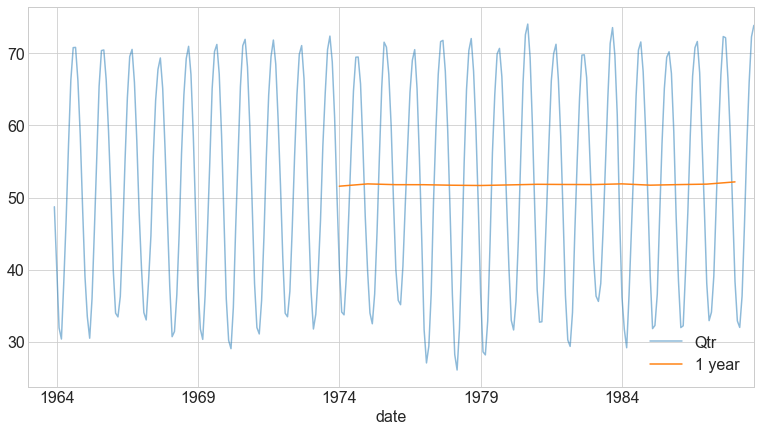

In [37]:
y.resample('M').mean().rolling(4).mean().plot(alpha=.5, label='Qtr')
y.resample('Y').mean().rolling(12).mean().plot(alpha=8, label='1 year')
plt.legend()

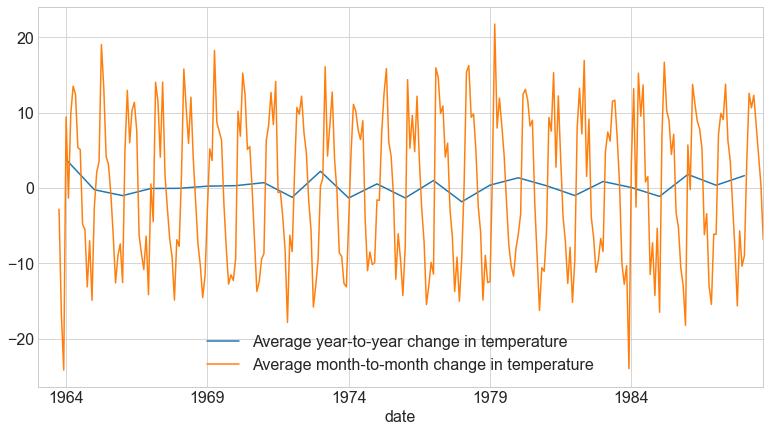

In [41]:
y.resample('Y').mean().diff().plot(label='Average year-to-year change in temperature')
y.resample('M').mean().diff().plot(label='Average month-to-month change in temperature')
plt.legend()

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='date'>

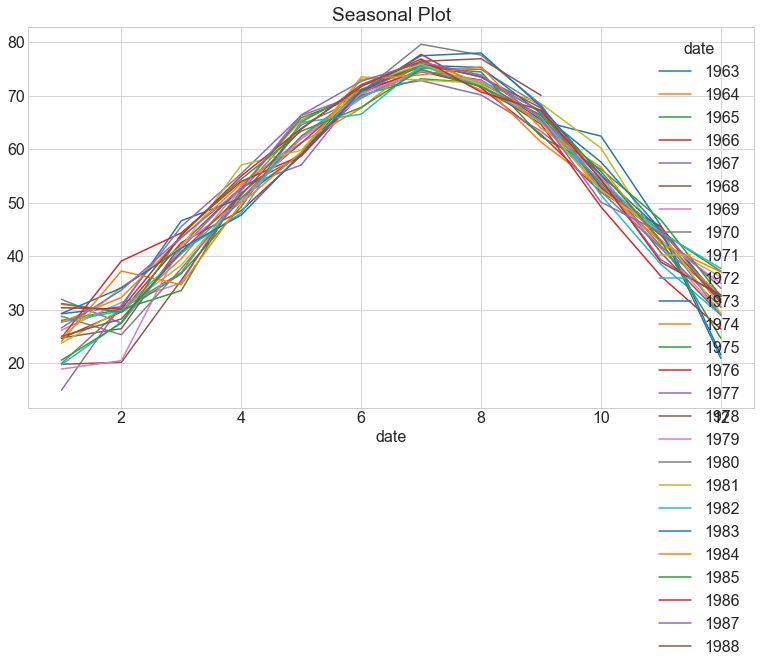

In [44]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

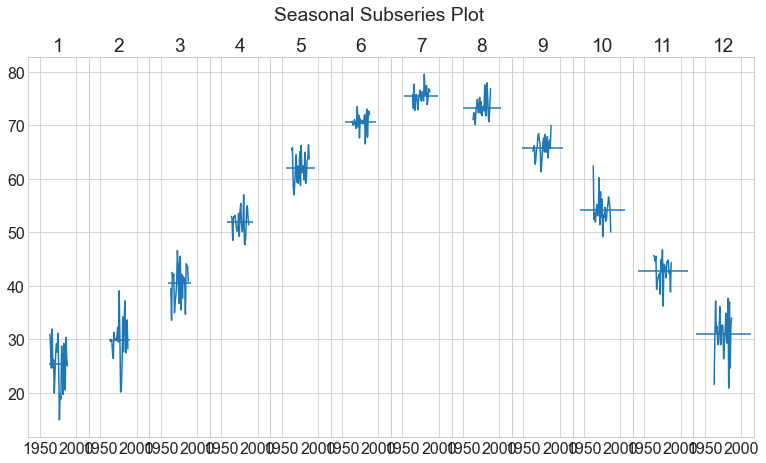

In [45]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim())
    ax.set(xlabel='')

fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=0)

Text(0.5, 1.0, 'Lag plot with lag=1')

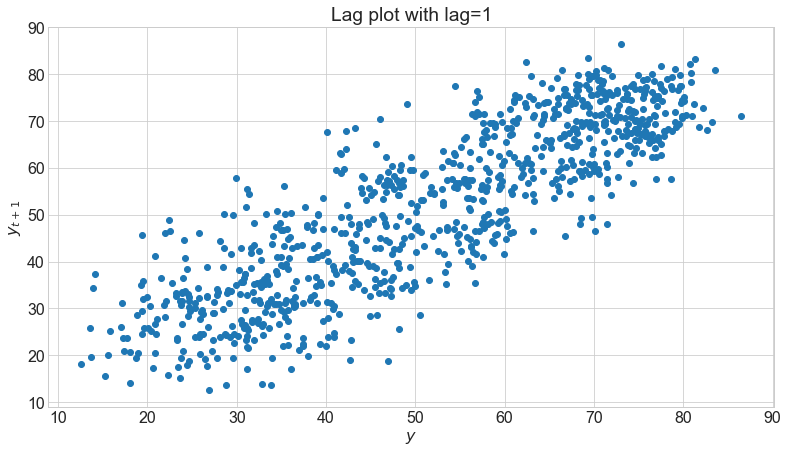

In [46]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

<ipython-input-48-83312c6d8430>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y(t + 1)'] = train.avg_temp.shift(-1)


[Text(0.5, 0, 't'), Text(0, 0.5, 't + 1')]

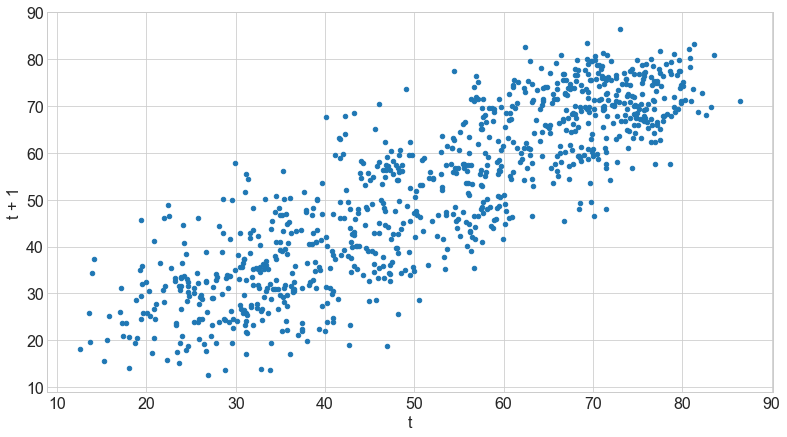

In [48]:
train['y(t + 1)'] = train.avg_temp.shift(-1)
ax = train.plot.scatter(x='avg_temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 26)'>

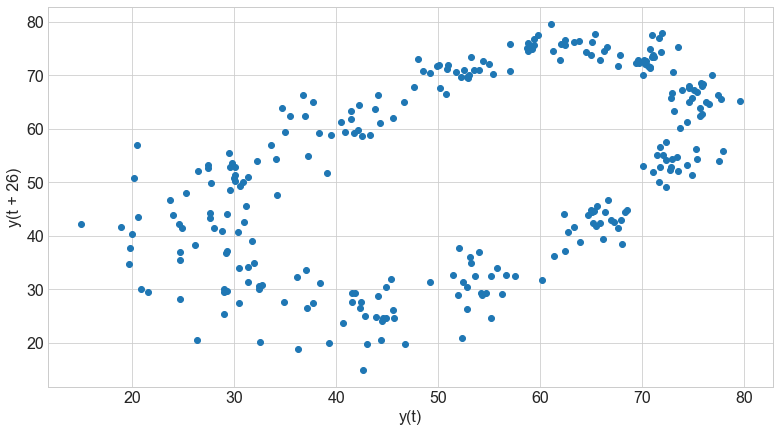

In [55]:
pd.plotting.lag_plot(train.avg_temp.resample('M').mean(), lag=26)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 52)'>

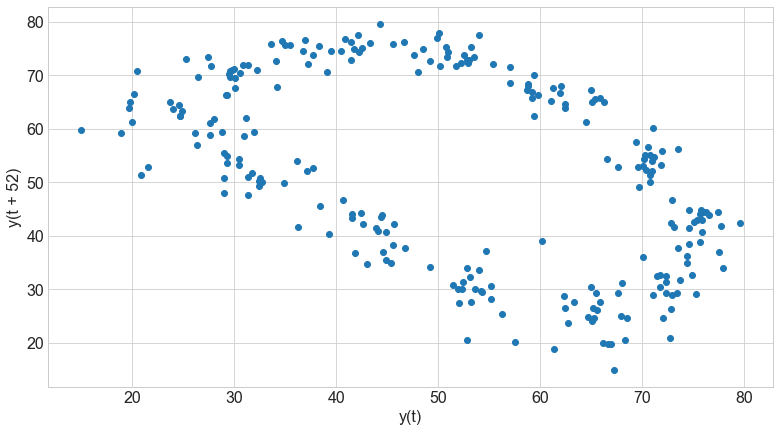

In [56]:
pd.plotting.lag_plot(train.avg_temp.resample('M').mean(), lag=52)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 5)'>

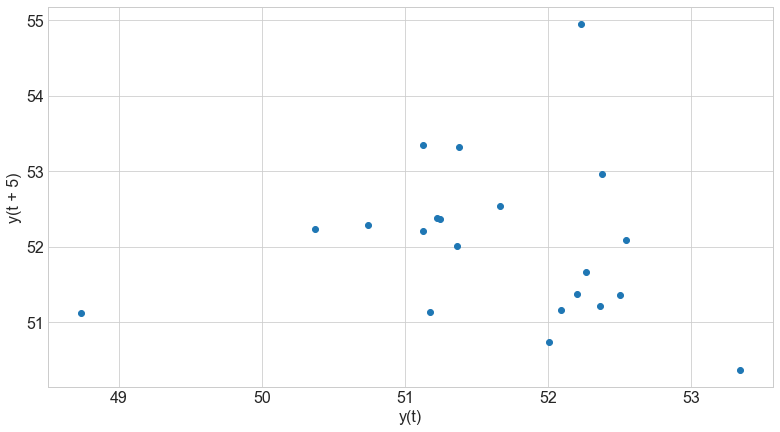

In [52]:
pd.plotting.lag_plot(train.avg_temp.resample('Y').mean(), lag=5)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

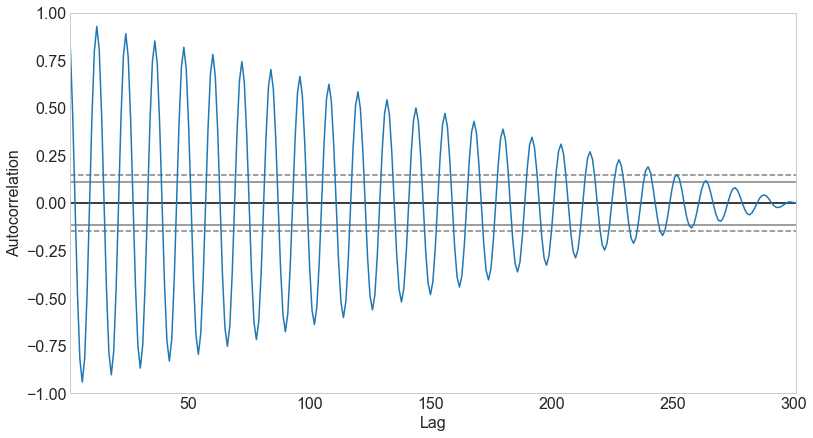

In [59]:
pd.plotting.autocorrelation_plot(train.avg_temp.resample('M').mean())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

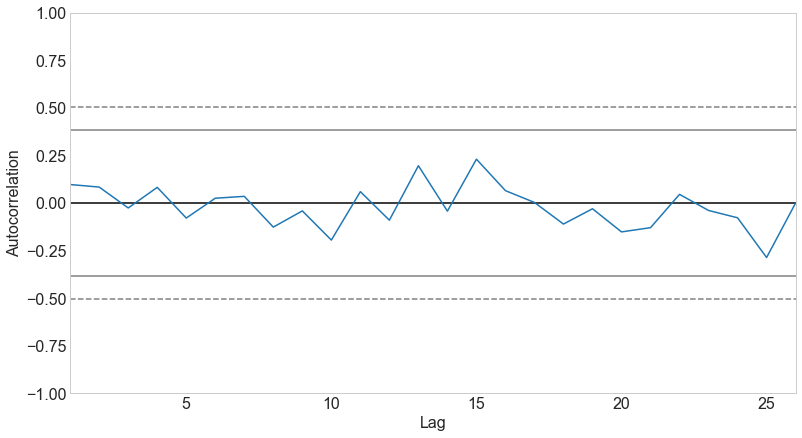

In [60]:
pd.plotting.autocorrelation_plot(train.avg_temp.resample('Y').mean())

In [62]:
y = train.avg_temp.resample('M').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
date,,,,
1963-09-30,65.25,NaN,13.87,NaN
1963-10-31,62.43,NaN,2.04,NaN
1963-11-30,45.70,NaN,-9.13,NaN
1963-12-31,21.55,NaN,-20.48,NaN
1964-01-31,30.97,NaN,-26.76,NaN


<AxesSubplot:xlabel='date'>

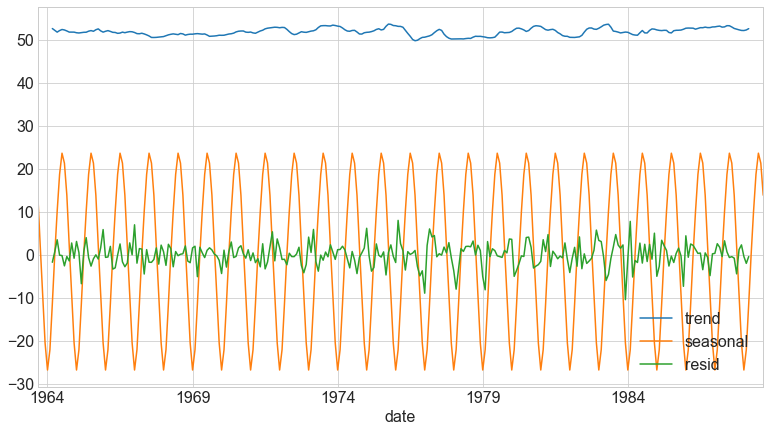

In [63]:
decomposition.iloc[:, 1:].plot()

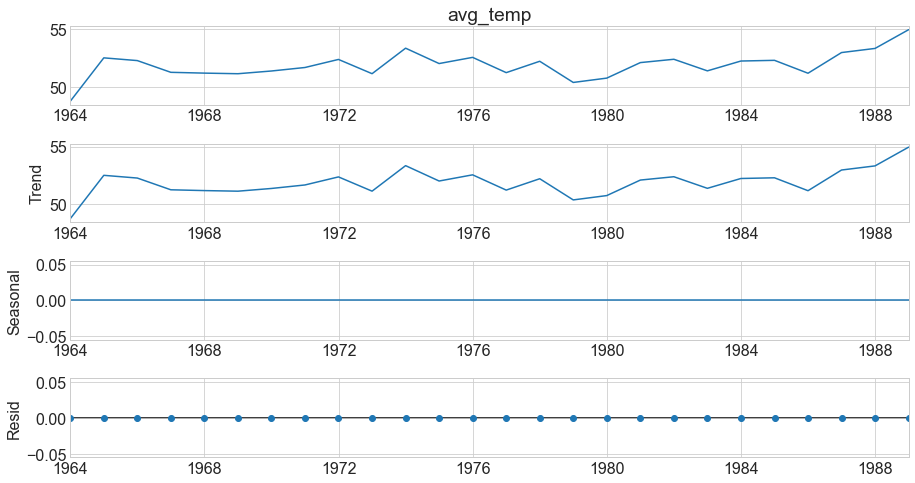

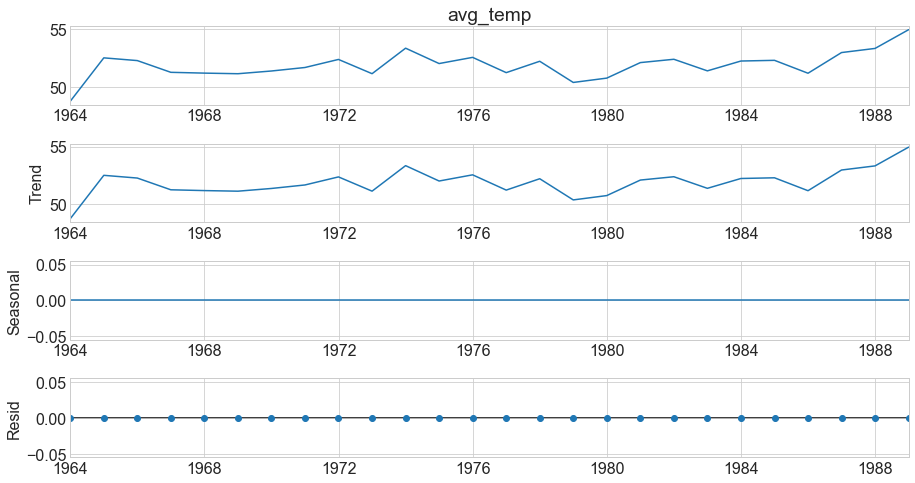

In [66]:
result.plot()

In [64]:
y = train.avg_temp.resample('Y').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
date,,,,
1963-12-31,48.73,48.73,0.00,0.00
1964-12-31,52.50,52.50,0.00,0.00
1965-12-31,52.27,52.27,0.00,0.00
1966-12-31,51.25,51.25,0.00,0.00
1967-12-31,51.18,51.18,0.00,0.00


<AxesSubplot:xlabel='date'>

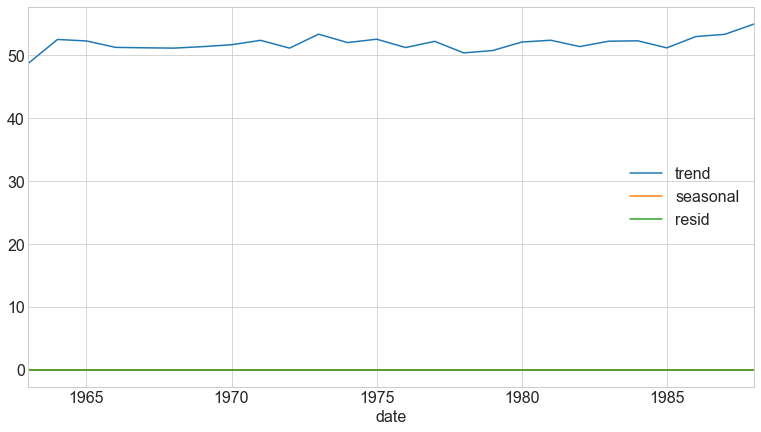

In [65]:
decomposition.iloc[:, 1:].plot()

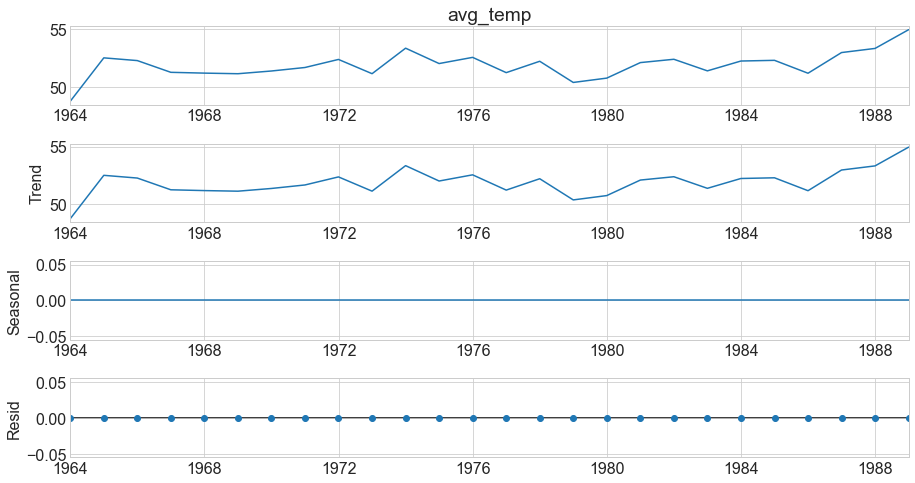

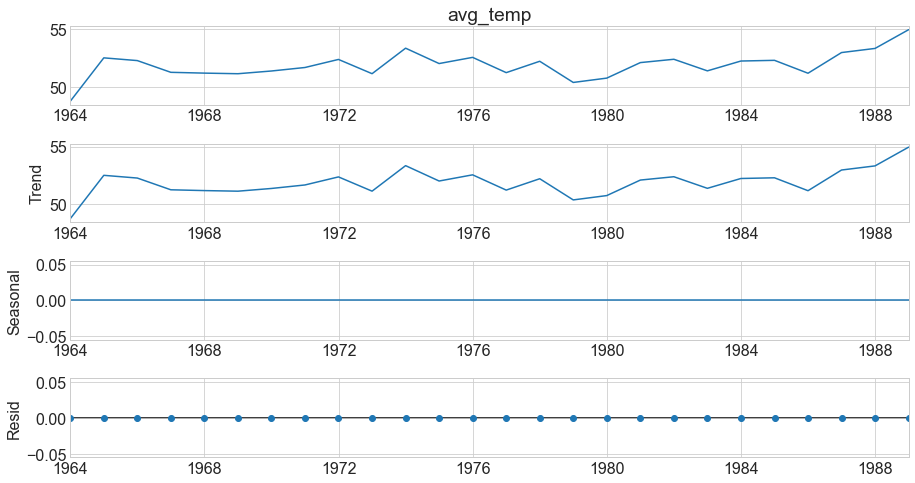

In [67]:
result.plot()

In [68]:
train = train.resample('M').mean()
# create a categorical feature
train['avgtemp_bin'] = pd.qcut(train.avg_temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('avgtemp_bin').mean()

,avg_temp,avgtemp_uncertainty,latitude,longitude,y(t + 1)
avgtemp_bin,,,,,
cold,28.63,32.55,39.92,85.01,30.04
cool,45.17,32.48,39.92,85.01,45.20
warm,61.13,32.47,39.92,85.01,60.40
hot,73.22,32.54,39.89,85.13,72.59


####Model